In [1]:
import os
import re
import glob
import yaml

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import zarr
import napari
import tifffile
import dask.array as da

from utils.utility_functions import single_channel_pyramid

In [2]:
# I/O
sample = 'CRC-097'

# import Leiden-clustered single-cell data
data = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# read OME-TIFF, segmentation outlines, and H&E channels
tif_path = os.path.join(os.getcwd(), f'input/{sample}_image.ome.tif')
seg_path = os.path.join(os.getcwd(), f'input/{sample}_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), 'input/hema_eosin.ome.tif')

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# get markers excluded from analysis
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['markersToExclude']

# import image contrast settings
with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast_limits = yaml.safe_load(f)

# isolate antibodies of interest
abx_channels = [
    i for i in data.columns if 'nucleiRingMask' in i
    if 'Hoechst' not in i if i not in markers_to_exclude
]

# get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

out = os.path.join(os.getcwd(), 'output/cluster12_crosstalk')
if not os.path.exists(out):
    os.makedirs(out)

CD8a histogram


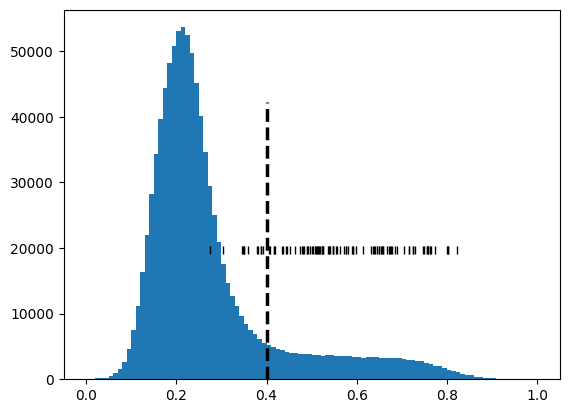

In [3]:
# plot CD8a histogram
plt.hist(data['CD8a_660_nucleiRingMask'], bins=100, color='tab:blue')

# add rug plot showing where specific cluster 12 cells reside in the distribution
y_max = plt.gca().get_ylim()[1]
test = data[data['cluster_2d'] == 12]
test = test.sample(n=100, random_state=1)
for i in test.index:
    x = data['CD8a_660_nucleiRingMask'][data.index == i]
    plt.plot(x.item(), y_max*0.35, marker='|', color='k', zorder=2.0)

# apply gate
plt.axvline(x=0.4, ymin=0, ymax=0.75, color='k', linestyle='--', lw=2.5, zorder=3)

plt.savefig(os.path.join(out, 'cd8a_hist.pdf'), bbox_inches='tight')
print('CD8a histogram')
plt.show()
plt.close('all')

Keratin histogram


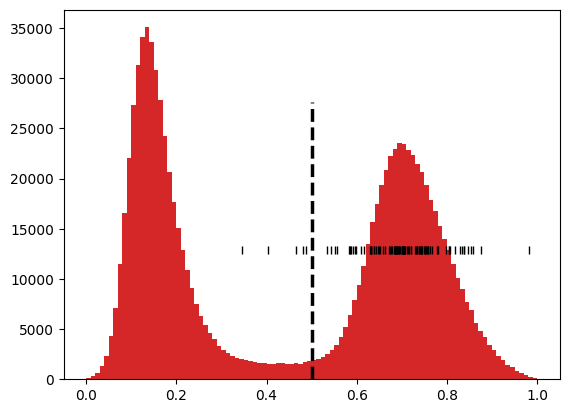

In [4]:
# plot Keratin histogram 
plt.hist(data['Keratin_570_nucleiRingMask'], bins=100, color='tab:red')

# add rug plot showing where specific cluster 12 cells reside in distribution
y_max = plt.gca().get_ylim()[1]
test = data[data['cluster_2d'] == 12]
test = test.sample(n=100, random_state=3)
for i in test.index:
    x = data['Keratin_570_nucleiRingMask'][data.index == i]
    plt.plot(x, y_max*0.35, marker='|', color='k', zorder=2.0)

# apply gate
plt.axvline(x=0.5, ymin=0, ymax=0.75, color='k', linestyle='--', lw=2.5, zorder=3)

plt.savefig(os.path.join(out, 'keratin_hist.pdf'), bbox_inches='tight')
print('Keratin histogram')
plt.show()
plt.close('all')

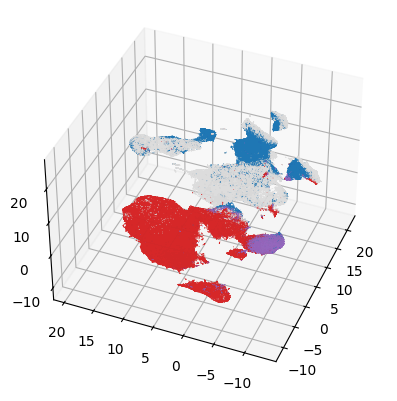

color
gainsboro     37.107248
tab:blue      11.205776
tab:purple     3.817142
tab:red       47.869834
dtype: float64


In [5]:
# plot 3D UMAP embedding and color by gating cutoffs

# get row IDs for gated cells
cd8a_ids = data.index[
    (data['CD8a_660_nucleiRingMask'] >= 0.4) & (data['Keratin_570_nucleiRingMask'] < 0.5)
]
keratin_ids = data.index[
    (data['CD8a_660_nucleiRingMask'] < 0.4) & (data['Keratin_570_nucleiRingMask'] >= 0.5)
]
cd8a_keratin_ids = data.index[
    (data['CD8a_660_nucleiRingMask'] >= 0.4) & (data['Keratin_570_nucleiRingMask'] >= 0.5)
]
other_ids = data.index[
    (data['CD8a_660_nucleiRingMask'] < 0.4) & (data['Keratin_570_nucleiRingMask'] < 0.5)
]

# assign gated cells to different colors
data.loc[cd8a_ids, 'color'] = 'tab:blue'
data.loc[keratin_ids, 'color'] = 'tab:red'
data.loc[cd8a_keratin_ids, 'color'] = 'tab:purple'
data.loc[other_ids, 'color'] = 'gainsboro'

fig = plt.figure()
ax = plt.axes(projection='3d', computed_zorder=False)
ax.view_init(azim=-158, elev=39)

ax.scatter(
    data['emb1'], data['emb2'], data['emb3'], c=data['color'],
    linewidth=0.1, s=150000 / len(data), alpha=1
)
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)

plt.savefig(os.path.join(out, 'embedding.png'), bbox_inches='tight', dpi=800)
plt.show()
plt.close('all')

# print cell percentages:
# total (gainsboro)
# keratin+/CD8- (red)
# CD8+/keratin- (blue)
# CD8+/keratin+ (purple)
percents = (data.groupby('color').size() / data.shape[0]) * 100
print(percents)

total CD8T cells:15.02


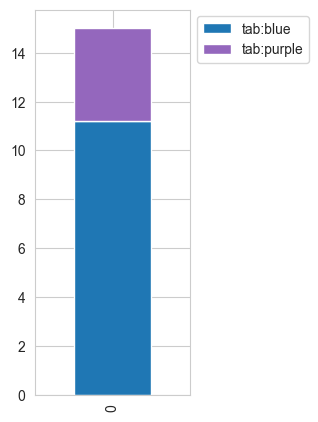

In [6]:
total_cd8s = percents['tab:blue'] + percents['tab:purple']

print(f'total CD8T cells:{round(total_cd8s, 2)}')

test = percents[['tab:blue', 'tab:purple']]

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(2, 5))

pd.DataFrame(test).T.plot.bar(ax=ax, stacked=True, color=['tab:blue', 'tab:purple'])

plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(out, 'stacked_bar.pdf'), bbox_inches='tight')
plt.show()
plt.close('all')

Cluster 12 only: color
gainsboro      0.043629
tab:blue       4.447581
tab:purple    81.611703
tab:red       13.897087
dtype: float64


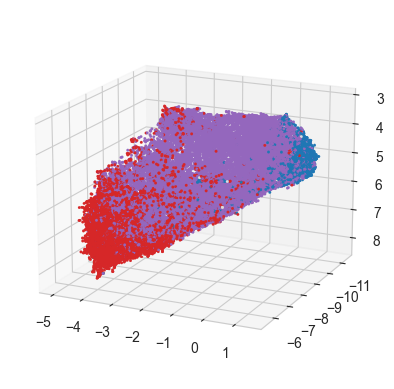

In [7]:
# show 3D UMAP embedding of cluster 12 cells only colored by gating cutoffs 
data = data[
    (data['emb1'] > -5) & (data['emb1'] < 5) &
    (data['emb2'] < -5.5) & (data['emb2'] > -12) &
    (data['emb3'] > 0) & (data['emb3'] < 10)
]

percents = (data.groupby('color').size() / data.shape[0]) * 100
print(f'Cluster 12 only: {percents}')

fig = plt.figure()
ax = plt.axes(projection='3d', computed_zorder=False)
ax.view_init(azim=-115, elev=-163)

ax.scatter(
    data['emb1'], data['emb2'], data['emb3'], c=data['color'],
    linewidth=0.1, s=150000 / len(data), alpha=1
)
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)
plt.savefig(os.path.join(out, 'L12_embedding.png'), bbox_inches='tight', dpi=800)
plt.show()
plt.close('all')

In [8]:
# initialize image viewer
viewer = napari.Viewer()

In [9]:
# loop over antibodies of interest, add to image viewer, and apply contrast limits
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(
        glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
    )
    
    if ch == 'CD8a_660':
        c = [0.12, 0.47, 0.71]
        visible = True
    elif ch == 'Keratin_570':
        c = [0.84, 0.15, 0.16]
        visible = True
    else:
        c = [0.17, 0.63, 0.17]
        visible = False
    
    viewer.add_image(
        img, rgb=False, blending='additive', colormap=np.array(c), visible=visible,
        name=ch, contrast_limits=(min, max)
    )

for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    viewer.layers[ch].contrast_limits = (
        contrast_limits[ch][0], contrast_limits[ch][1])

In [10]:
# add centroids of cluster 12 cells to image viewer
for c, cluster in zip([[1.0, 1.0, 1.0]], [12]):
    centroids = data[['Y_centroid', 'X_centroid']][data['cluster_2d'] == cluster]
    viewer.add_points(
        centroids, name=f'Cluster{cluster}', face_color=np.array(c), edge_color=c, edge_width=0.0,
        size=3.0, opacity=1.0, blending='opaque', visible=True
    )

In [11]:
# add segmentation outlines to image viewer
seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3
)

<Image layer 'segmentation' at 0x165ec6880>

In [12]:
# add DNA1 channel to image viewer
dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True, opacity=0.8,
    name='DNA1', contrast_limits=(min, max)
)

<Image layer 'DNA1' at 0x159d75cd0>

In [13]:
# run image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()